# Project Statement: Forecasting Air Pollution in Quito Using Time Series Analysis and Machine Learning

#### Integrantes:
- Enrique Merizalde
- Juan Aristizabal
- Domenica Escobar
- Jossue Játiva

#### Fecha de inicio: 12/04/2025

## CARGAR Y CONSOLIDAR:

Cargar conjunto de datos de 10 estaciones con variables como PM2.5, CO2 y Velocidad del viento. Consolidar en un DataFrame unificado, gestionando los datos faltantes con imputacion y visualizando las lagunas con missingno. Estandarizar formatos y remuestrar para predicciones mensuales (Suma de precipitación, media, etc.) y horas mediante pandas

In [158]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [159]:
# Ruta de la carpeta con los archivos CSV
folder_path = 'Data/'

# Obtener la lista de archivos CSV
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Cargar el archivo estaciones.csv para obtener LAT y LON
estaciones_path = os.path.join(folder_path, 'estaciones.csv')
estaciones_df = pd.read_csv(estaciones_path)

# Crear un DataFrame vacío con las columnas esperadas
column_names = [
    "STATION_NAME", "LAT", "LON", "Date_time",
    "CO", "DIR", "HUM", "LLU", "NO2", "O3",
    "PM2.5", "PM10", "PRE", "RS", "TMP", "VEL"
]
final_df = pd.DataFrame(columns=column_names)

In [160]:
# Iterar sobre cada archivo CSV
for file in csv_files:
    if file == 'estaciones.csv':
        continue  # Saltar el archivo estaciones.csv
    
    # Leer el archivo CSV
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    
    # Identificar la variable que contiene este archivo (basado en el nombre del archivo)
    variable_name = file.split('.')[0].upper()  # Asumimos que el nombre del archivo indica la variable
    
    # Transformar el DataFrame a formato largo (long format)
    df_long = df.melt(id_vars=["Date_time"], var_name="STATION_NAME", value_name=variable_name)
    
    # Unir con las coordenadas de las estaciones
    df_long = df_long.merge(estaciones_df, left_on="STATION_NAME", right_on="STATION", how="left")
    
    # Reorganizar columnas
    df_long = df_long[["STATION_NAME", "LAT", "LON", "Date_time", variable_name]]
    
    # Combinar con el DataFrame final
    if final_df.empty:
        final_df = df_long
    else:
        final_df = pd.merge(final_df, df_long, on=["STATION_NAME", "LAT", "LON", "Date_time"], how="outer")

<Axes: >

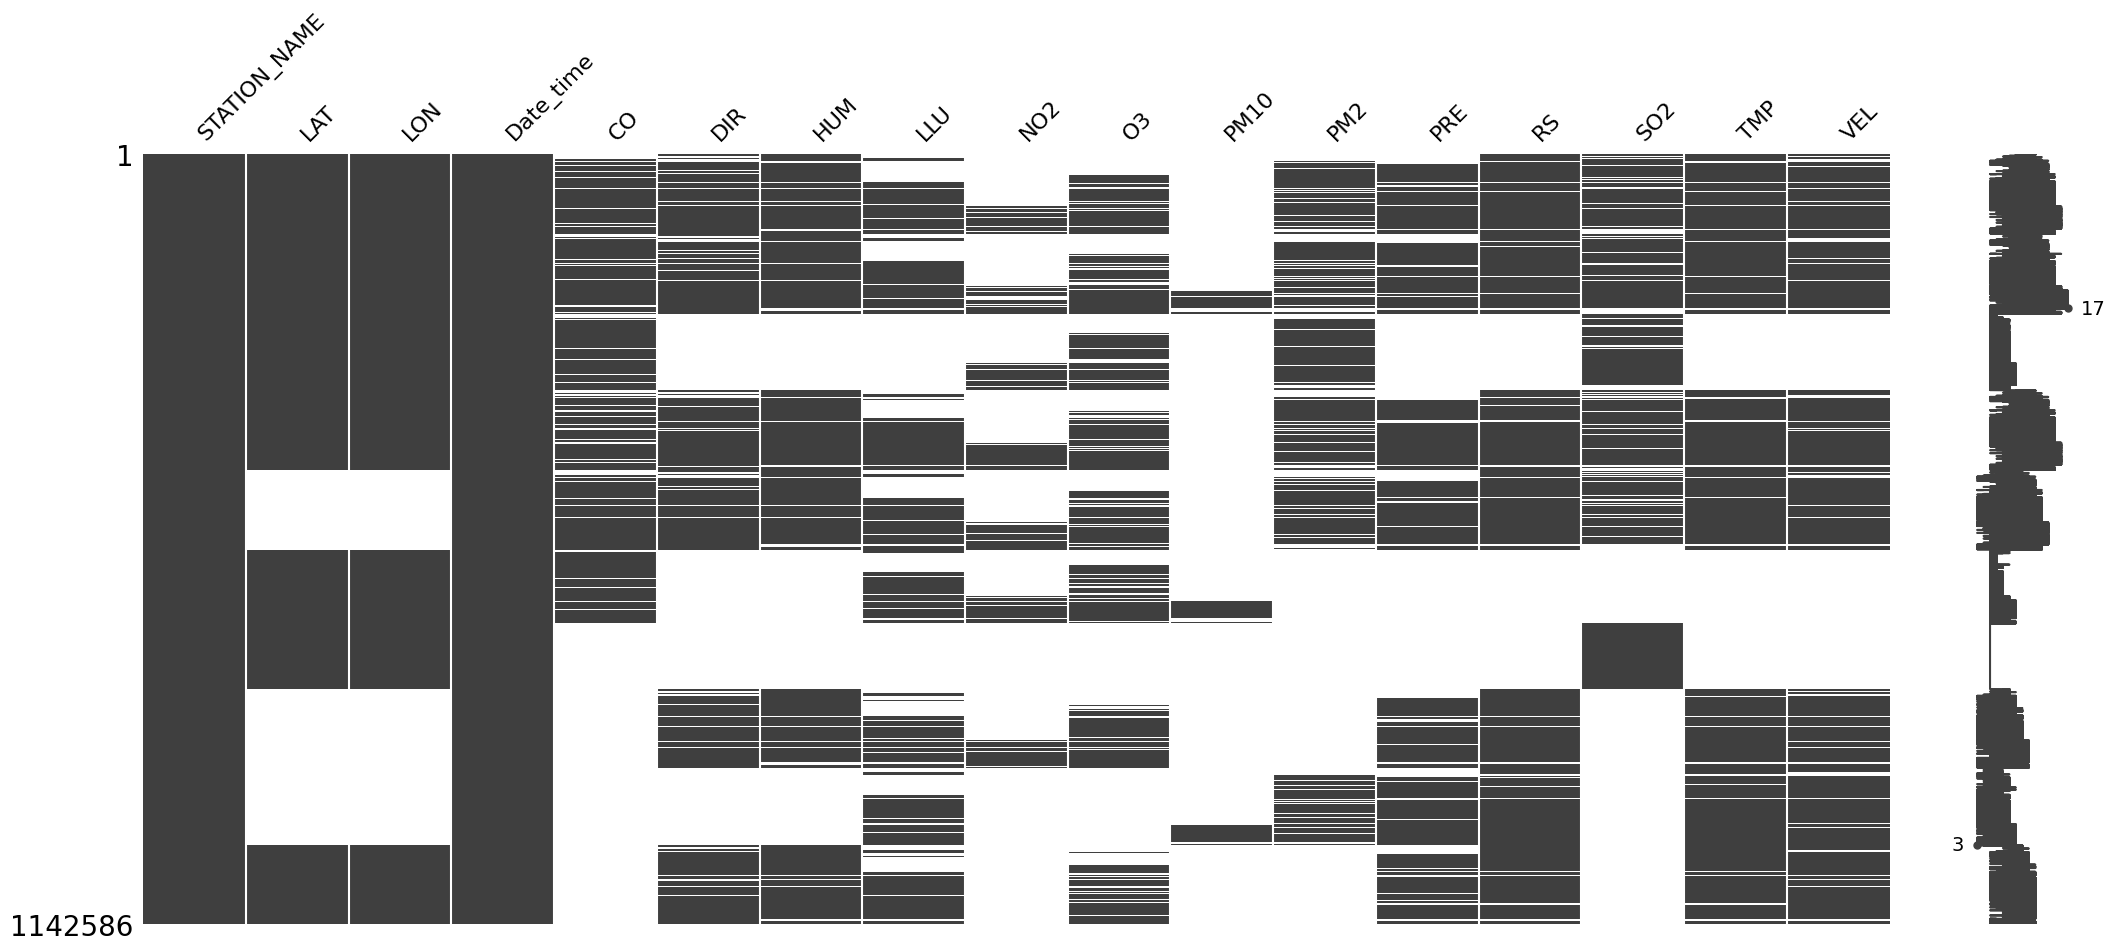

In [161]:
# Limpiar la columna Date_time eliminando caracteres no deseados
final_df["Date_time"] = final_df["Date_time"].astype(str).str.replace(r"\.0$", "", regex=True)

# Convertir la columna Date_time a formato datetime
final_df["Date_time"] = pd.to_datetime(final_df["Date_time"], errors="coerce")

# Verificar si hay valores no convertidos
if final_df["Date_time"].isnull().any():
    print("Advertencia: Algunos valores en 'Date_time' no se pudieron convertir. Revisa los datos.")
    display(final_df[final_df["Date_time"].isnull()])

# Continuar con el análisis
msno.matrix(final_df)

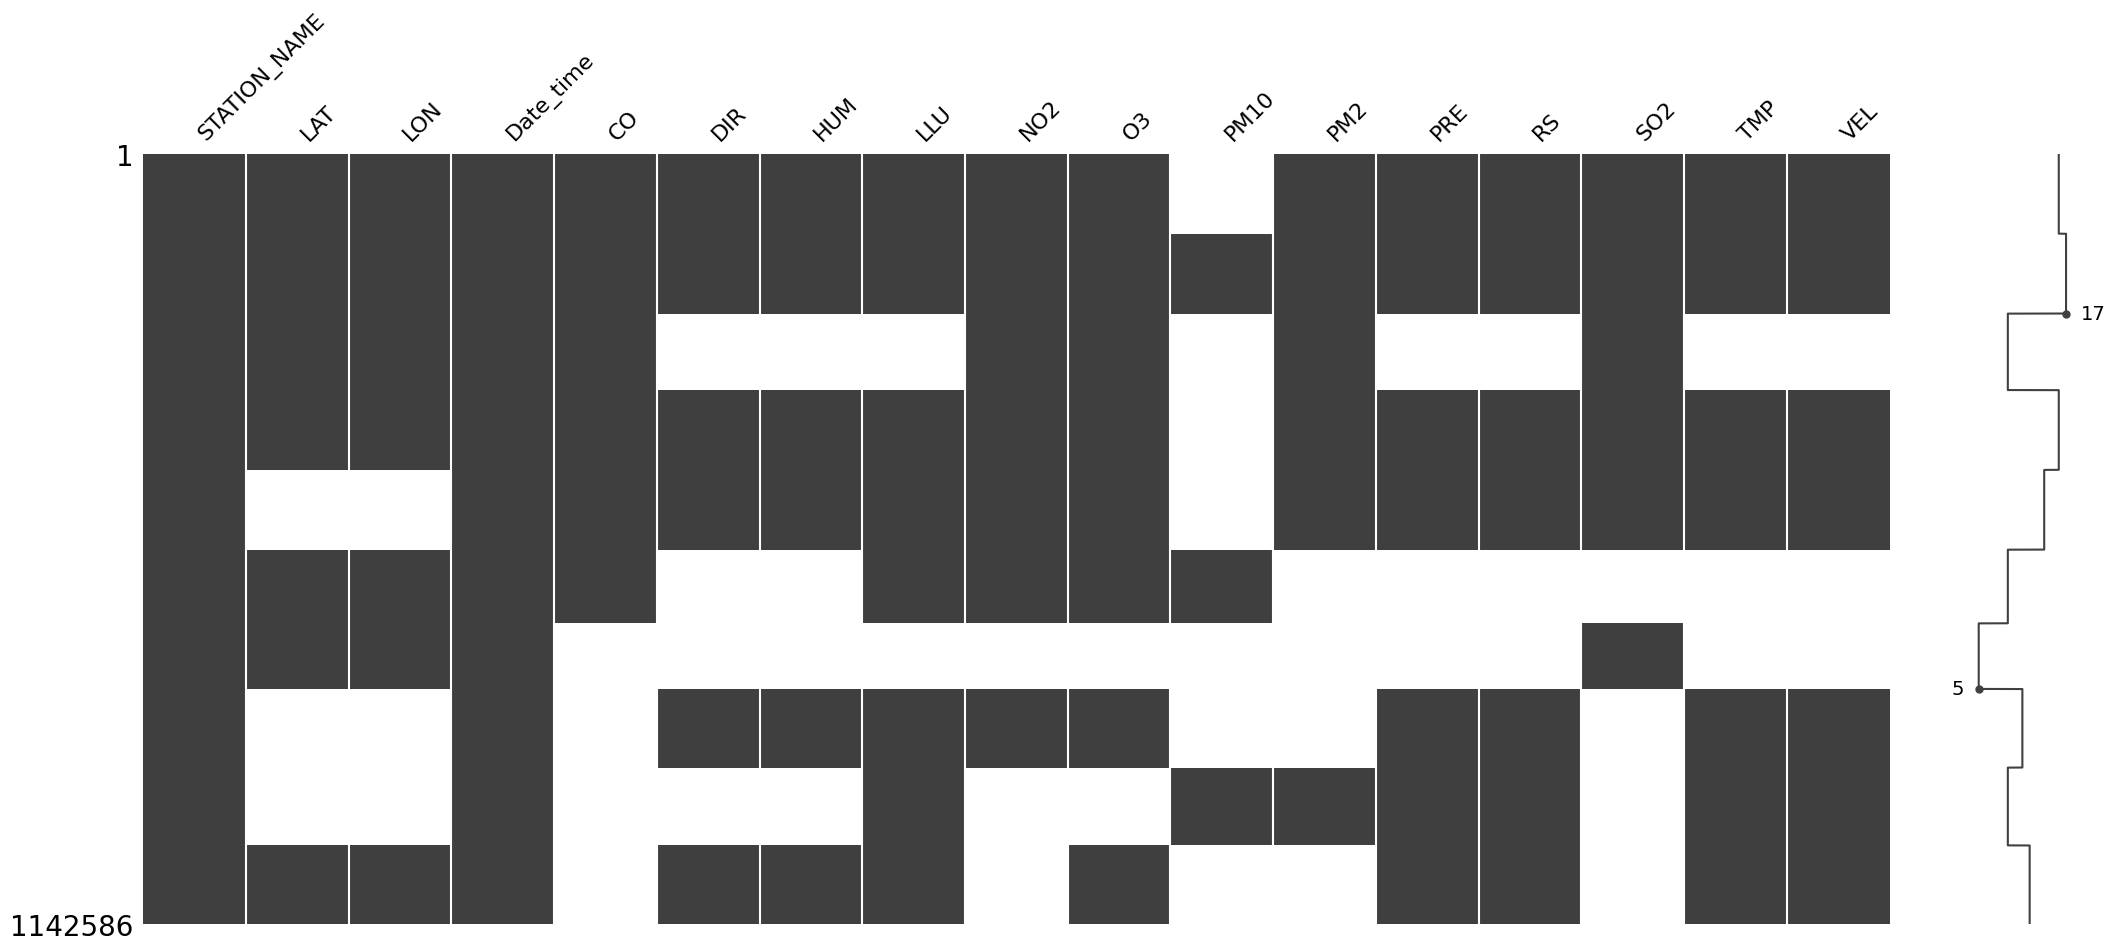

In [162]:
# Limpiar la columna Date_time eliminando caracteres no deseados
final_df["Date_time"] = final_df["Date_time"].astype(str).str.replace(r"\\.0$", "", regex=True)

# Convertir la columna Date_time a formato datetime
final_df["Date_time"] = pd.to_datetime(final_df["Date_time"], errors="coerce")

# Verificar si hay valores no convertidos
if final_df["Date_time"].isnull().any():
    print("Advertencia: Algunos valores en 'Date_time' no se pudieron convertir. Revisa los datos.")
    display(final_df[final_df["Date_time"].isnull()])

# Ordenar el DataFrame por STATION_NAME y Date_time
final_df = final_df.sort_values(by=["STATION_NAME", "Date_time"])

# Lista de columnas a rellenar
columns_to_fill = ["CO", "DIR", "HUM", "LLU", "NO2", "O3", "PM10", "PM2", "PRE", "RS", "SO2", "TMP", "VEL"]

# Rellenar los valores NaN utilizando el método ffill (hacia adelante) y luego bfill (hacia atrás) por cada estación
final_df[columns_to_fill] = final_df.groupby("STATION_NAME", group_keys=False)[columns_to_fill].apply(lambda x: x.ffill().bfill())

msno.matrix(final_df)
plt.show()

## Exploratory Data Analysis (EDA)

Visualizaremos tendencias temporales, patrones estacionales y relaciones entre variables usando reducción de dimensionalidad.

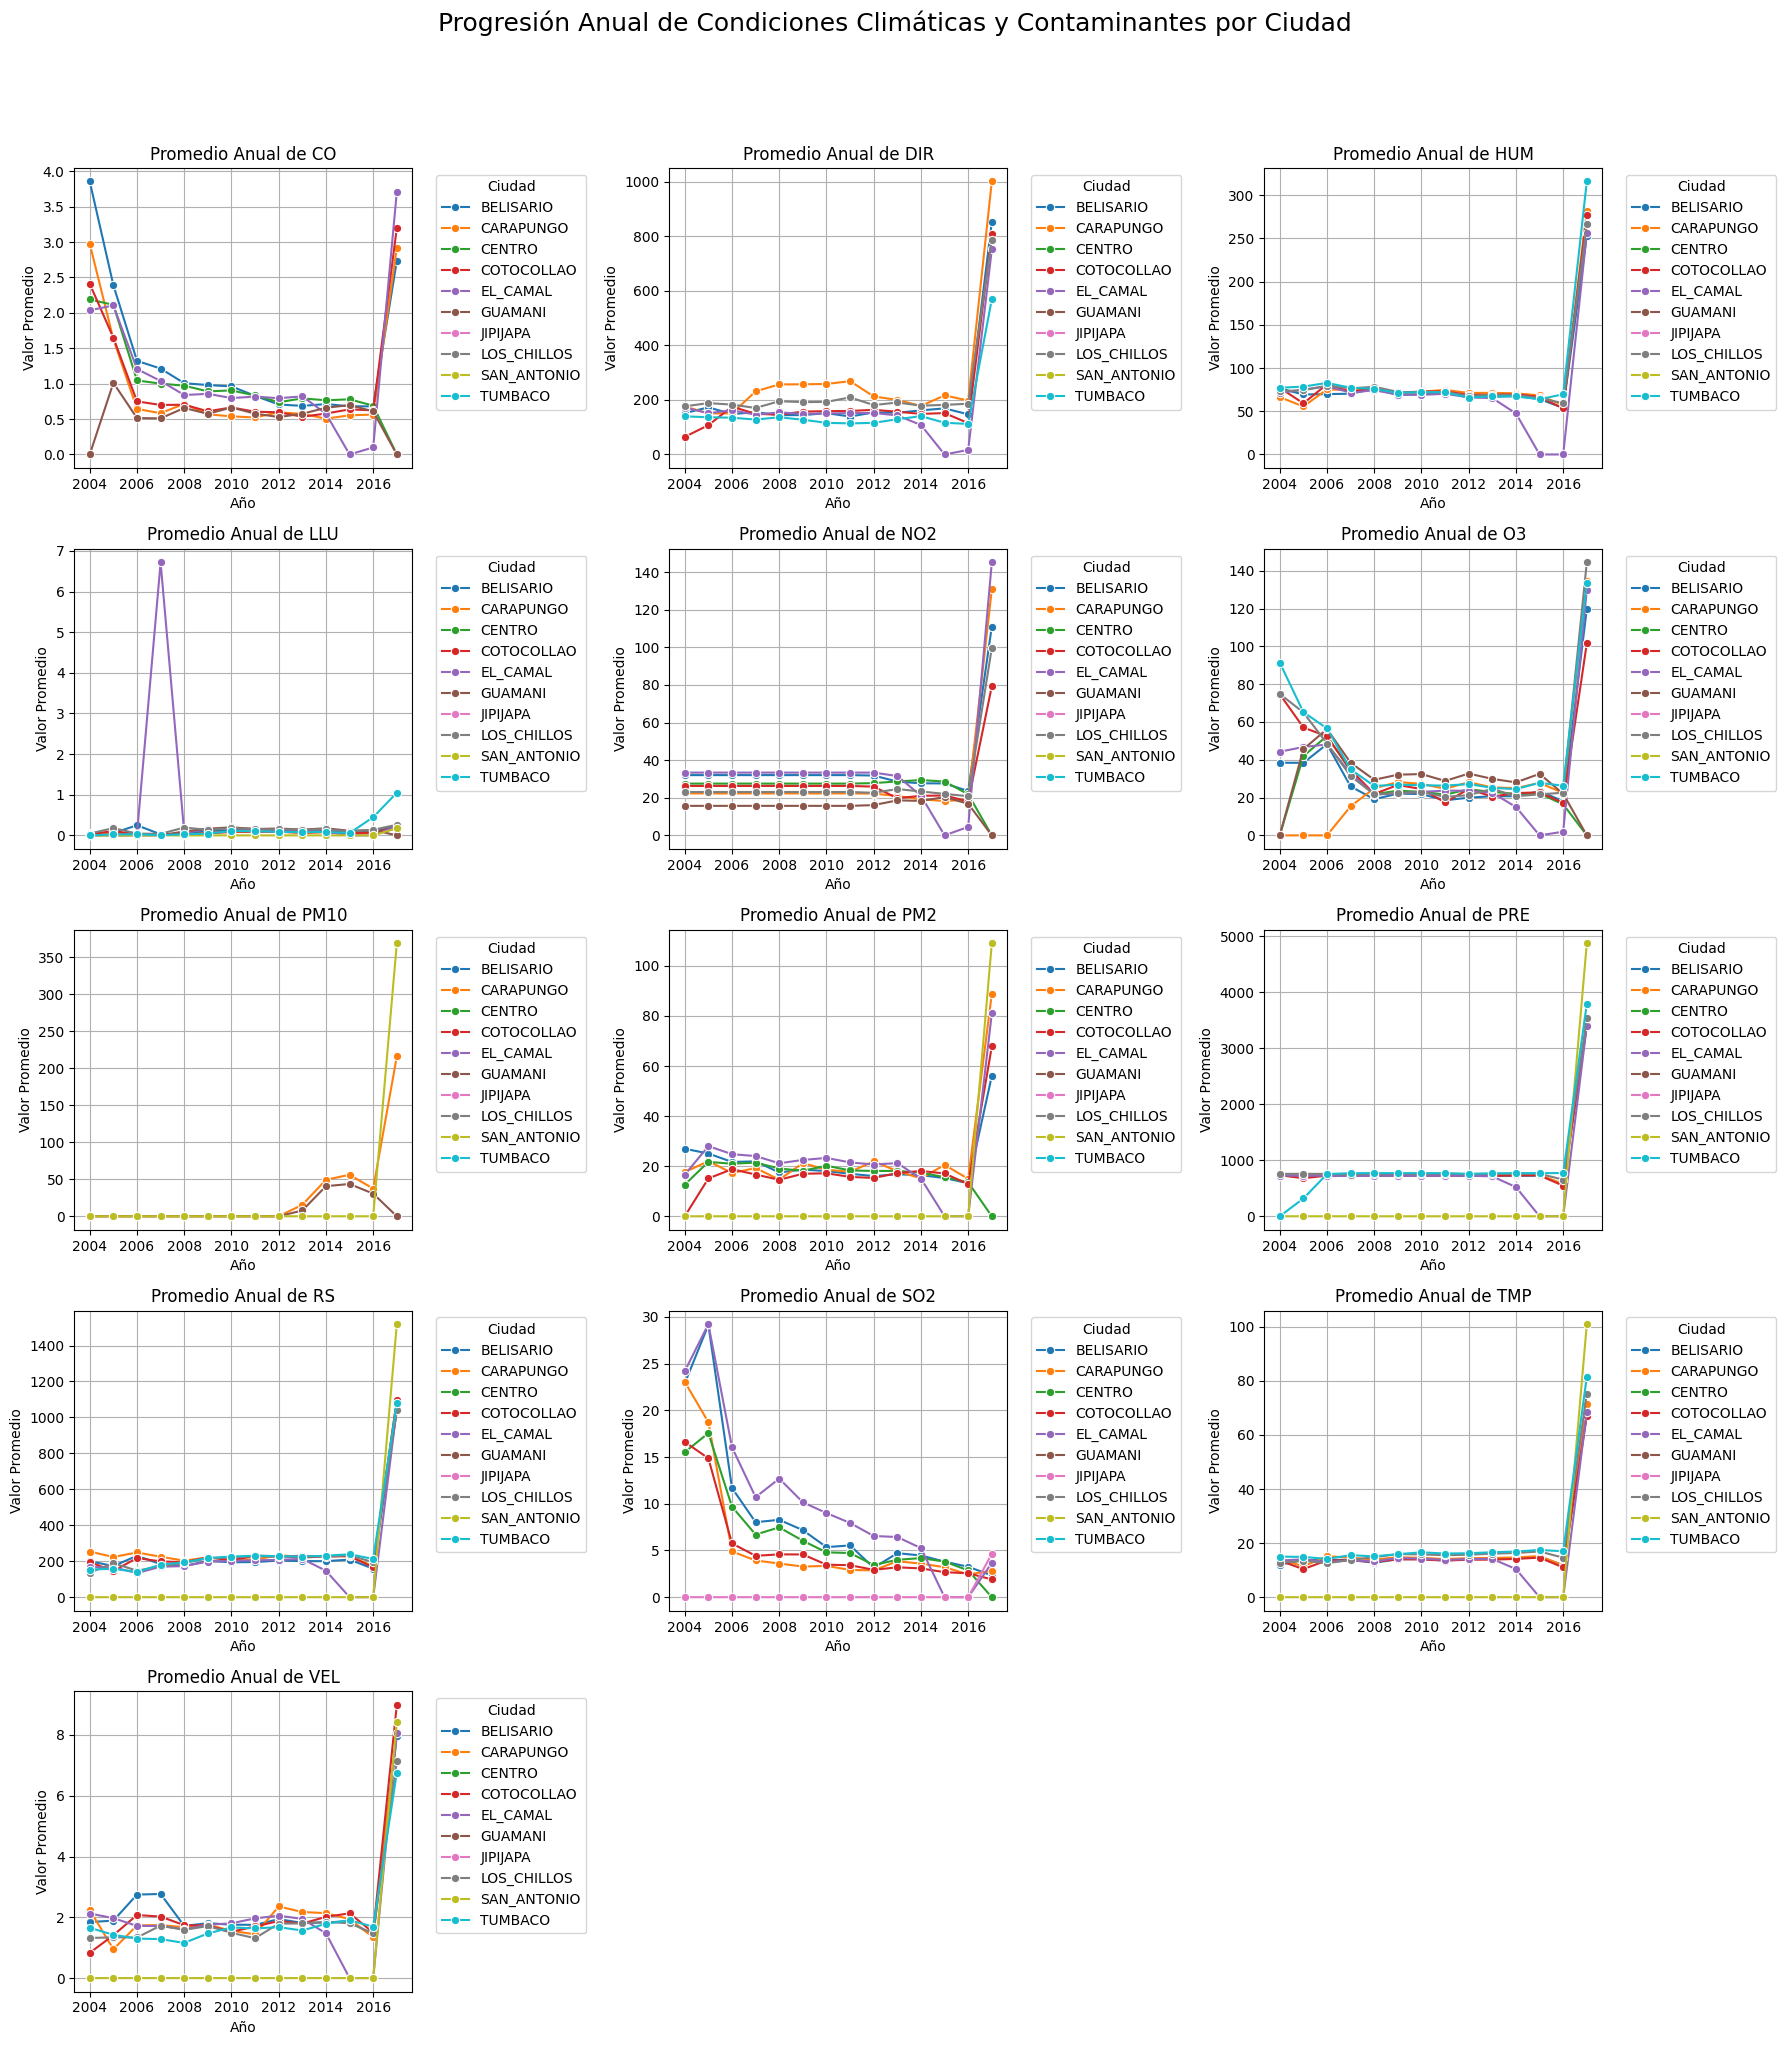

In [163]:
# Asegurarse que Date_time es datetime
final_df['Date_time'] = pd.to_datetime(final_df['Date_time'])

# Extraer el año
final_df['Year'] = final_df['Date_time'].dt.year

# Columnas de mediciones climáticas y contaminantes
measurement_columns = ["CO", "DIR", "HUM", "LLU", "NO2", "O3", "PM10", "PM2", "PRE", "RS", "SO2", "TMP", "VEL"]

# Agrupar por Año y Estación y calcular la media
# Usaremos el nombre de la estación como 'Ciudad' para la leyenda
yearly_data = final_df.groupby(['Year', 'STATION_NAME'])[measurement_columns].mean().reset_index()

# Graficar cada medición en un subplot separado
num_cols_plot = 3 # Número de columnas de subplots
num_rows_plot = (len(measurement_columns) + num_cols_plot - 1) // num_cols_plot # Calcular filas necesarias

plt.figure(figsize=(18, num_rows_plot * 4)) # Ajustar el tamaño de la figura
plt.suptitle('Progresión Anual de Condiciones Climáticas y Contaminantes por Ciudad', fontsize=18, y=1.02)

for i, col_name in enumerate(measurement_columns):
    plt.subplot(num_rows_plot, num_cols_plot, i + 1)
    # Usar hue para diferenciar por STATION_NAME (Ciudad)
    sns.lineplot(data=yearly_data, x='Year', y=col_name, hue='STATION_NAME', marker='o', legend=True)
    plt.title(f'Promedio Anual de {col_name}')
    plt.xlabel('Año')
    plt.ylabel('Valor Promedio')
    plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left') # Ajustar posición de la leyenda
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para el suptitle y leyendas

In [164]:
# Asegurarse que Date_time es datetime
if not pd.api.types.is_datetime64_any_dtype(final_df['Date_time']):
    final_df['Date_time'] = pd.to_datetime(final_df['Date_time'])

# Crear una copia del DataFrame con Date_time como índice para trabajar específicamente con PM2.5
# Usamos .copy() para evitar SettingWithCopyWarning si se hacen modificaciones posteriores
df_pm25_prepared = final_df.set_index('Date_time').copy()

# Define el nombre de la columna objetivo para PM2.5
# Asegúrate de que este sea el nombre exacto de la columna en tu DataFrame 'final_df'
target_column_name = 'PM2' 

# Verificar si la columna objetivo existe en el DataFrame
if target_column_name not in df_pm25_prepared.columns:
    print(f"Error: La columna '{target_column_name}' no se encuentra en el DataFrame.")
    print(f"Columnas disponibles: {df_pm25_prepared.columns.tolist()}")
    # Considera detener la ejecución o manejar este error según sea necesario
    # Por ejemplo: raise ValueError(f"Columna '{target_column_name}' no encontrada.")
    # O asignar un DataFrame vacío para que las comprobaciones posteriores fallen de forma controlada
    df_pm25_prepared = pd.DataFrame() 
else:
    # 1. Seleccionar solo la columna objetivo (PM2.5) y eliminar filas donde esta columna sea NaN.
    # Esto es fundamental para que los lags se creen a partir de valores reales y no de NaNs.
    # Al seleccionar una sola columna y aplicar dropna(), nos aseguramos de que solo se consideren los NaNs de esta columna.
    df_pm25_prepared = df_pm25_prepared[[target_column_name]].dropna()

    # Verificar si quedan datos después de este primer paso de limpieza
    if df_pm25_prepared.empty:
        print(f"Advertencia: No quedan datos para la columna '{target_column_name}' después de eliminar sus valores NaN iniciales.")
        print("No se puede continuar con la creación de características ni el modelado para PM2.5.")
    else:
        # 2. Crear características de lag (valores pasados de PM2.5).
        # Usaremos los 3 valores anteriores de PM2.5 como características para predecir el valor actual.
        # El nombre de la columna en df_pm25_prepared es ahora target_column_name (ej. 'PM2.5')
        for i in range(1, 4):  # Crear lags: PM2.5_lag_1, PM2.5_lag_2, PM2.5_lag_3
            df_pm25_prepared[f'{target_column_name}_lag_{i}'] = df_pm25_prepared[target_column_name].shift(i)

        # 3. Eliminar las filas que ahora contienen NaNs debido a la operación de shift().
        # Estas son las primeras filas de la serie para las cuales no se pudieron calcular todos los lags.
        # Estas filas no pueden usarse para entrenar el modelo ya que les faltarían características.
        df_pm25_prepared = df_pm25_prepared.dropna()

        # Informar sobre el estado de los datos preparados
        if df_pm25_prepared.empty:
            print(f"Advertencia: No quedan datos después de crear los lags y eliminar los NaNs resultantes para '{target_column_name}'.")
            print("No se puede continuar con el modelado para PM2.5.")
        else:
            print(f"Datos para '{target_column_name}' listos para el modelado.")
            print(f"Forma del DataFrame preparado (df_pm25_prepared): {df_pm25_prepared.shape}")

Datos para 'PM2' listos para el modelado.
Forma del DataFrame preparado (df_pm25_prepared): (702680, 4)


In [168]:
# Lista para guardar resultados por ciudad y mes
results_list = []

# Asegurar formato de fecha
final_df['Date_time'] = pd.to_datetime(final_df['Date_time'])
final_df['Year'] = final_df['Date_time'].dt.year
final_df['Month'] = final_df['Date_time'].dt.month

# Resumen de datos válidos por ciudad
for station in final_df['STATION_NAME'].unique():
    total = final_df[final_df['STATION_NAME'] == station].shape[0]
    valid = final_df[final_df['STATION_NAME'] == station]['PM2'].dropna().shape[0]

# Entrenamiento por ciudad y mes
for station in final_df['STATION_NAME'].unique():
    station_df = final_df[final_df['STATION_NAME'] == station].copy()
    station_df = station_df.set_index('Date_time')
    
    for (year, month), monthly_df in station_df.groupby([station_df.index.year, station_df.index.month]):
        if monthly_df['PM2'].dropna().shape[0] < 10:
            continue

        # Crear dataset con lags
        station_pm25 = monthly_df[['PM2']].dropna()
        for i in range(1, 4):
            station_pm25[f'PM2_lag_{i}'] = station_pm25['PM2'].shift(i)
        station_pm25 = station_pm25.dropna()

        if station_pm25.shape[0] < 10:
            continue

        # Variables predictoras y objetivo
        X = station_pm25[[f'PM2_lag_{i}' for i in range(1, 4)]]
        y = station_pm25['PM2']

        # Escalamiento y split
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)

        # Entrenamiento
        model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric="rmse"
        )
        model.fit(X_train, y_train)

        # Predicción
        y_pred = model.predict(X_test)

        # Guardar resultados
        df_results = pd.DataFrame({
            'Date_time': y_test.index,
            'PM2_real': y_test.values,
            'PM2_pred': y_pred,
            'STATION_NAME': station,
            'Year': year,
            'Month': month
        })
        results_list.append(df_results)

# Concatenar resultados
if results_list:
    all_results = pd.concat(results_list)
else:
    print("\n⚠️ No se entrenó ningún modelo (no había suficientes datos).")

# Asegurar que all_results tiene las columnas necesarias y formato de fecha
all_results['Date_time'] = pd.to_datetime(all_results['Date_time'])
all_results['Year'] = all_results['Date_time'].dt.year
all_results['Month'] = all_results['Date_time'].dt.month

# Promedio mensual real por ciudad (de final_df)
real_pm2_monthly = (
    final_df[['Date_time', 'STATION_NAME', 'PM2']]
    .dropna()
    .assign(Year=final_df['Date_time'].dt.year, Month=final_df['Date_time'].dt.month)
    .groupby(['Year', 'Month', 'STATION_NAME'])['PM2']
    .mean()
    .reset_index()
    .rename(columns={'PM2': 'PM2_real'})
)

# Promedio mensual predicho por ciudad (de all_results)
pred_pm2_monthly = (
    all_results.groupby(['Year', 'Month', 'STATION_NAME'])['PM2_pred']
    .mean()
    .reset_index()
    .rename(columns={'PM2_pred': 'PM2_predicted'})
)

# Combinar ambos DataFrames para comparación mensual
combined_df = pd.merge(real_pm2_monthly, pred_pm2_monthly, on=['Year', 'Month', 'STATION_NAME'], how='inner')


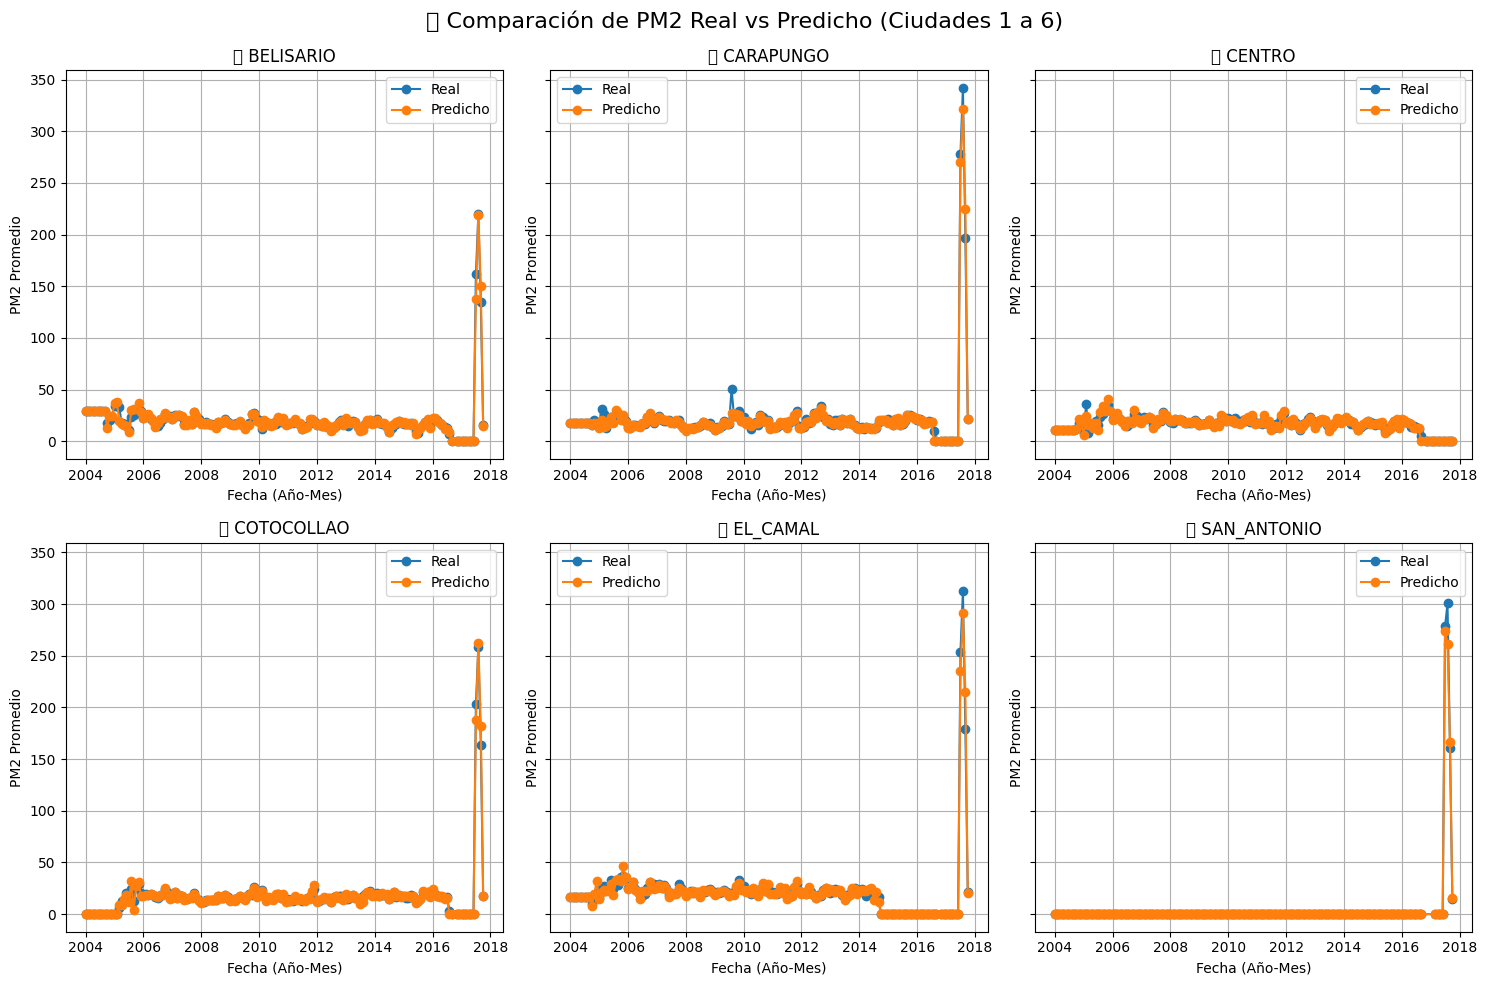

In [171]:
cities = combined_df['STATION_NAME'].unique()
n_per_fig = 6  # 3 filas * 2 columnas

for start_idx in range(0, len(cities), n_per_fig):
    subset_cities = cities[start_idx:start_idx + n_per_fig]
    
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharey=True)
    axes = axes.flatten()  # Para indexar fácilmente
    
    for ax_idx, ax in enumerate(axes):
        if ax_idx < len(subset_cities):
            city = subset_cities[ax_idx]
            city_df = combined_df[combined_df['STATION_NAME'] == city].copy()
            city_df['YearMonth'] = pd.to_datetime(city_df[['Year', 'Month']].assign(DAY=1))

            ax.plot(city_df['YearMonth'], city_df['PM2_real'], label='Real', marker='o')
            ax.plot(city_df['YearMonth'], city_df['PM2_predicted'], label='Predicho', marker='o')
            ax.set_title(f'📍 {city}')
            ax.set_xlabel('Fecha (Año-Mes)')
            ax.set_ylabel('PM2 Promedio')
            ax.grid(True)
            ax.legend()
        else:
            fig.delaxes(ax)  # Eliminar ejes sobrantes si hay menos ciudades que espacios
    
    plt.suptitle(f'📈 Comparación de PM2 Real vs Predicho (Ciudades {start_idx+1} a {start_idx+len(subset_cities)})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(top=0.92)  # Ajustar título superior
    plt.show()


Errores globales:
MAE: 1.315
MSE: 10.555
RMSE: 3.249


Tabla comparativa (primeras 20 filas):


,STATION_NAME,Year,Month,PM2_real,PM2_predicted
0,BELISARIO,2004,1,29.07,29.070000
1,CARAPUNGO,2004,1,17.37,17.370001
2,CENTRO,2004,1,11.14,11.140000
3,COTOCOLLAO,2004,1,0.00,0.000000
4,EL_CAMAL,2004,1,16.92,16.920000
5,SAN_ANTONIO,2004,1,0.00,0.000000
6,BELISARIO,2004,2,29.07,29.070000
7,CARAPUNGO,2004,2,17.37,17.370001
8,CENTRO,2004,2,11.14,11.140000
9,COTOCOLLAO,2004,2,0.00,0.000000


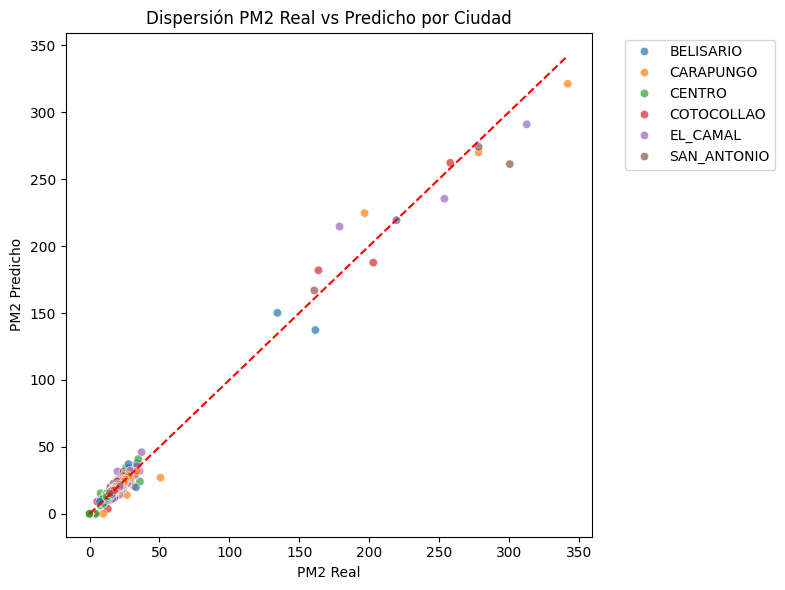

In [174]:
# 1. Calcular errores globales
mae_global = mean_absolute_error(combined_df['PM2_real'], combined_df['PM2_predicted'])
mse_global = mean_squared_error(combined_df['PM2_real'], combined_df['PM2_predicted'])
rmse_global = np.sqrt(mse_global)

print(f"Errores globales:")
print(f"MAE: {mae_global:.3f}")
print(f"MSE: {mse_global:.3f}")
print(f"RMSE: {rmse_global:.3f}\n")

# 2. Calcular errores por ciudad
errors_per_city = combined_df.groupby('STATION_NAME').apply(
    lambda df: pd.Series({
        'MAE': mean_absolute_error(df['PM2_real'], df['PM2_predicted']),
        'MSE': mean_squared_error(df['PM2_real'], df['PM2_predicted']),
        'RMSE': np.sqrt(mean_squared_error(df['PM2_real'], df['PM2_predicted']))
    })
).reset_index()

# 3. Mostrar tabla comparativa real vs predicho (puedes limitar la salida)
print("\nTabla comparativa (primeras 20 filas):")
display(combined_df[['STATION_NAME', 'Year', 'Month', 'PM2_real', 'PM2_predicted']].head(20))

# 4. (Opcional) Visualizar con seaborn una gráfica de dispersión para ver correlación real vs predicho

plt.figure(figsize=(8,6))
sns.scatterplot(data=combined_df, x='PM2_real', y='PM2_predicted', hue='STATION_NAME', alpha=0.7)
plt.plot([combined_df['PM2_real'].min(), combined_df['PM2_real'].max()],
         [combined_df['PM2_real'].min(), combined_df['PM2_real'].max()], 'r--')  # Línea 45°
plt.title("Dispersión PM2 Real vs Predicho por Ciudad")
plt.xlabel("PM2 Real")
plt.ylabel("PM2 Predicho")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
